# Representational Geodesic

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyrtools as pt
import plenoptic as po
from plenoptic.tools import to_numpy
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32
torch.__version__

'1.7.1'

## Translation

### Spectral models
Computing a geodesic to reveal excess invariance of the global Fourier magnitude representation.

/Users/aldebaran/Documents/plenoptic/plenoptic/tools/data.py:90: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  im = color.rgb2gray(im)
Image statistics:
  Range: [0.000000, 1.000000]
  Mean: 0.460425,  Stdev: 0.175550,  Kurtosis: 3.649574
Image statistics:
  Range: [0.000000, 0.995128]
  Mean: 0.413386,  Stdev: 0.197611,  Kurtosis: 2.456905
torch.Size([1, 1, 32, 32])
torch.Size([11, 1, 32, 32])
(11, 32, 32)


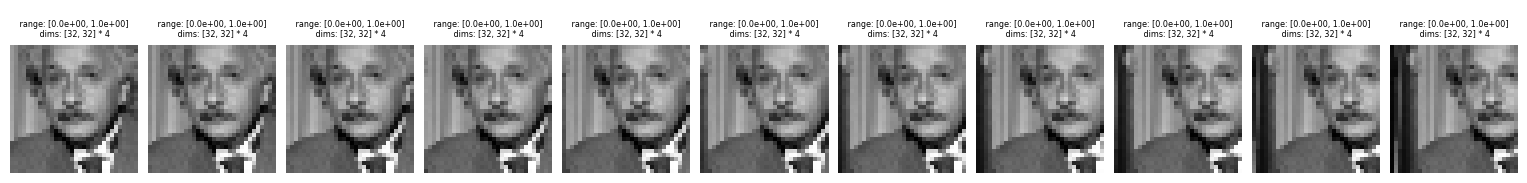

In [2]:
image_size = 64
einstein = po.load_images('../data/256/einstein.pgm')
einstein = po.tools.conv.blur_downsample(einstein, step=(4,4))
vid = po.tools.translation_sequence(einstein[0])
from torchvision.transforms.functional import center_crop
vid = center_crop(vid, image_size // 2)
vid = po.tools.rescale(vid, 0, 1)

imgA = vid[0:1]
imgB = vid[-1:]

pt.image_stats(to_numpy(imgA))
pt.image_stats(to_numpy(imgB))
print(imgA.shape)
print(vid.shape)

# convention: full name for numpy arrays, short hands for torch tensors
video = to_numpy(vid).squeeze()
print(video.shape)
# pt.animshow(video, zoom=4)
pt.imshow(list(video.squeeze()), zoom=4);

In [3]:
import torch.fft
class Fourier(nn.Module):
    def __init__(self, representation = 'amp'):
        super().__init__()
        self.representation = representation
        
    def spectrum(self, x):
        return torch.fft.rfftn(x, dim=(2, 3))

    def forward(self, x):
        if self.representation == 'amp':
            return torch.abs(self.spectrum(x))
        elif self.representation == 'phase':
            return torch.angle(self.spectrum(x))
        elif self.representation == 'rectangular':
            return self.spectrum(x)
        elif self.representation == 'polar':
            return torch.cat((torch.abs(self.spectrum(x)),
                              torch.angle(self.spectrum(x))),
                             dim=1)

model = Fourier('amp')
# model = Fourier('polar') # note: need pytorch>=1.8 to take gradients through torch.angle 

In [7]:
class Normalize(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.div(x, x.pow(2).sum(dim=(1,2,3), keepdim=True).pow(.5))
model = Normalize()

In [35]:
n_steps = len(video)-1
moog = po.synth.Geodesic(imgA, imgB, model, n_steps, init='bridge')
moog.synthesize(max_iter=500, learning_rate=.01, lmbda=.1, mu=1, nu=0)

100%|██████████| 500/500 [00:01<00:00, 300.93it/s, loss=3.4429e-03, gradient norm=1.0204e-05, lr=0.01]


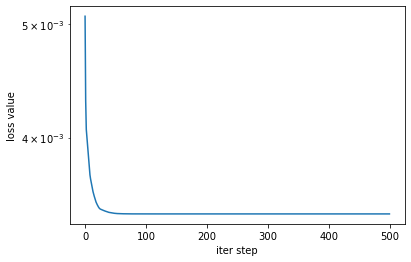

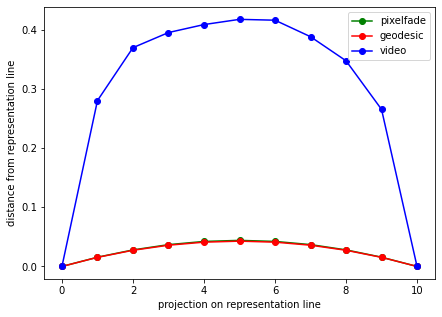

In [36]:
moog.plot_loss();
moog.plot_distance_from_line(vid);

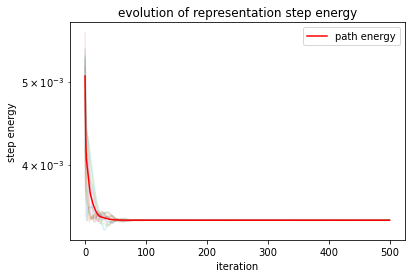

In [37]:
plt.plot([po.to_numpy(e) for e in moog.step_energy], alpha=.2);
plt.plot([e.mean() for e in moog.step_energy], 'r-', label='path energy')
plt.legend()
plt.title('evolution of representation step energy')
plt.ylabel('step energy')
plt.xlabel('iteration')
plt.yscale('log')
plt.show()

In [38]:
torch.norm(moog._analyze(moog.xA) - moog._analyze(moog.xB)) ** 2 / 10

tensor(0.0335)

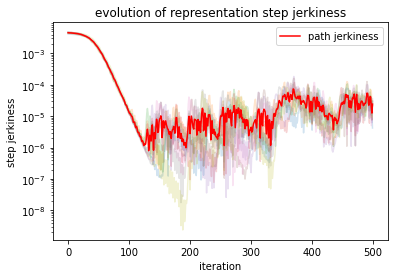

In [39]:
plt.plot([po.to_numpy(j) for j in moog.step_jerkiness], alpha=.2);
plt.plot([j.mean() for j in moog.step_jerkiness], 'r-', label='path jerkiness');
plt.legend()
plt.title('evolution of representation step jerkiness')
plt.ylabel('step jerkiness')
plt.xlabel('iteration')
plt.yscale('log')
plt.show()

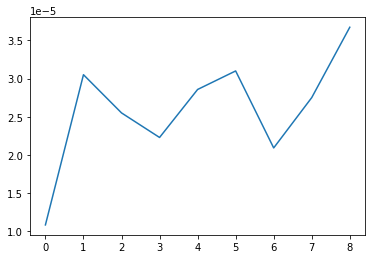

In [40]:
plt.plot(moog._step_jerkiness(moog._analyze(torch.cat([moog.xA, moog.x, moog.xB])), moog._finite_difference(moog._analyze(torch.cat([moog.xA, moog.x, moog.xB])))).detach())

In [9]:
try:
    moog.animate_distance_from_line(vid).save("../logs/distfromline_fourieramp_translation.mp4")
except:
    print('generating the animation takes time, therefore we dont do it by default')
    
    plt.plot(po.to_numpy(torch.stack(moog.dist_from_line, 0)[:, 1:-1]))

    plt.title('evolution of distance from representation line')
    plt.ylabel('distance from representation line')
    plt.xlabel('iteration step')
    # plt.yscale('log')
    plt.show()

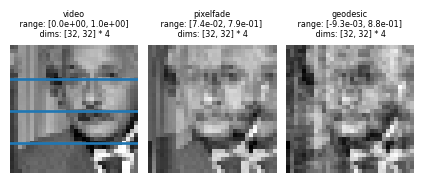

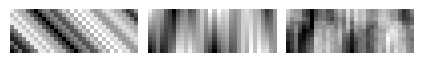

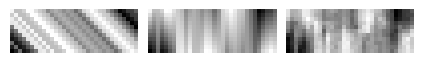

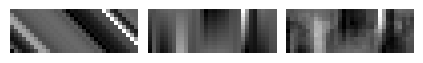

In [15]:
pixelfade = to_numpy(moog.pixelfade.squeeze())
geodesic = to_numpy(moog.geodesic.squeeze())
fig = pt.imshow([video[5], pixelfade[5], geodesic[5]],
          title=['video', 'pixelfade', 'geodesic'],
          col_wrap=3, zoom=4);

size = geodesic.shape[-1]
h, m , l = (size//2 + size//4, size//2, size//2 - size//4)

# for a in fig.get_axes()[0]:
a = fig.get_axes()[0]
for line in (h, m, l):
    a.axhline(line, lw=2)


pt.imshow([video[:,l], pixelfade[:,l], geodesic[:,l]],
          title=None, col_wrap=3, zoom=4);
pt.imshow([video[:,m], pixelfade[:,m], geodesic[:,m]],
          title=None, col_wrap=3, zoom=4);
pt.imshow([video[:,h], pixelfade[:,h], geodesic[:,h]],
          title=None, col_wrap=3, zoom=4);

### Physiologically inspired models

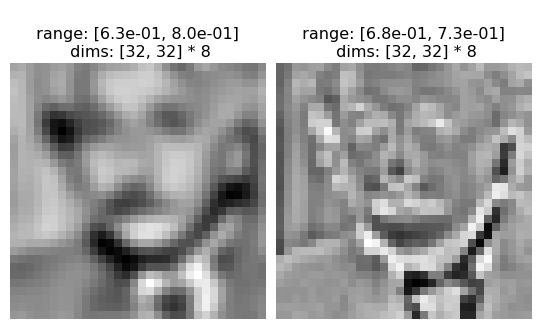

In [3]:
model = po.simul.OnOff(kernel_size=(31,31), pretrained=True)
po.imshow(model(imgA), zoom=8);
# po.imshow(model.conv.weight, zoom=28, vrange='auto0');

In [4]:
n_steps = 10

moog = po.synth.Geodesic(imgA, imgB, model, n_steps, init='straight')

print('shape trainable param', '# trainable param')
sum(p.numel() for p in moog.parameters())
[p.shape for p in moog.parameters() if p.requires_grad], sum(p.numel() for p in moog.parameters() if p.requires_grad)

shape trainable param # trainable param


([torch.Size([9, 1024])], 9216)

In [5]:
try:
    from adabelief_pytorch import AdaBelief
    import adabelief_pytorch
    print(adabelief_pytorch.__version__)
    optimizer = AdaBelief([moog.x], lr=0.001, eps=1e-16, betas=(0.9,0.999),
                          weight_decouple=True, rectify=False, print_change_log=False)
except:
    optimizer = 'Adam'

0.2.0
Weight decoupling enabled in AdaBelief


In [8]:
moog = po.synth.Geodesic(imgA, imgB, model, n_steps, init='straight')
moog.synthesize(optimizer=optimizer)

  1%|▏         | 14/1000 [00:04<04:54,  3.34it/s, loss=3.2325e-02, gradient norm=4.3829e-02, lr=0.001]


KeyboardInterrupt: 

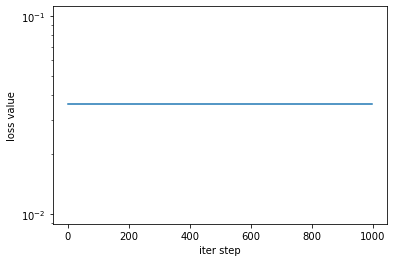

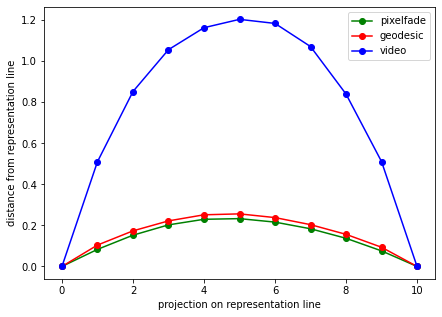

In [43]:
moog.plot_loss()
moog.plot_distance_from_line(vid);

In [16]:
try:
    moog.animate_distance_from_line(vid).save("../logs/distfromline_frontend_translation.mp4")
except:
    print('generating the animation takes time, therefore we dont do it by default')

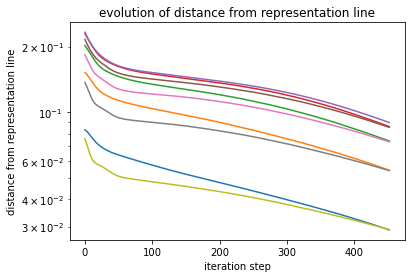

In [39]:
plt.plot(po.to_numpy(torch.stack(moog.dist_from_line, 0)[:, 1:-1]))

plt.title('evolution of distance from representation line')
plt.ylabel('distance from representation line')
plt.xlabel('iteration step')
plt.yscale('log')
plt.show()

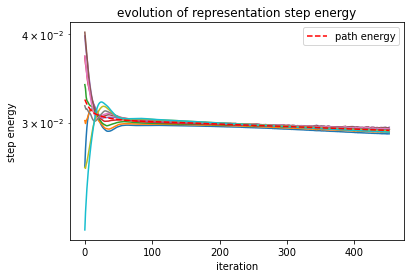

In [40]:
plt.plot([po.to_numpy(e) for e in moog.step_energy]);
plt.plot([e.mean() for e in moog.step_energy], 'r--', label='path energy')
plt.legend()
plt.title('evolution of representation step energy')
plt.ylabel('step energy')
plt.xlabel('iteration')
plt.yscale('log')
plt.show()

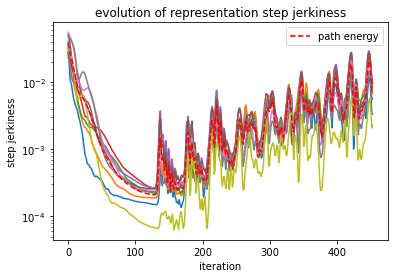

In [41]:
plt.plot([po.to_numpy(j) for j in moog.step_jerkiness]);
plt.plot([j.mean() for j in moog.step_jerkiness], 'r--', label='path energy');
plt.legend()
plt.title('evolution of representation step jerkiness')
plt.ylabel('step jerkiness')
plt.xlabel('iteration')
plt.yscale('log')
plt.show()

In [20]:
# pt.imshow(list(moog.yA[0]), col_wrap=4);
# pt.imshow(list(moog.yB[0]), col_wrap=4);

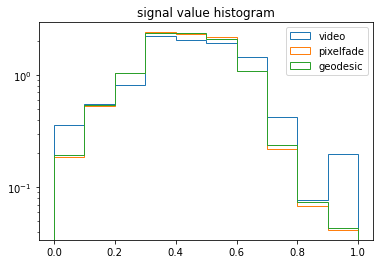

In [10]:
geodesic  = po.to_numpy(moog.geodesic).squeeze()
pixelfade = po.to_numpy(moog.pixelfade).squeeze()
assert geodesic.shape == pixelfade.shape

# checking that the range constraint is met
plt.hist(video.flatten(), histtype='step', density=True, label='video')
plt.hist(pixelfade.flatten(), histtype='step', density=True, label='pixelfade')
plt.hist(geodesic.flatten(), histtype='step', density=True, label='geodesic');
plt.yscale('log')
plt.title('signal value histogram')
plt.legend(loc=1)
plt.show()

geodesic
diff
pixelfade


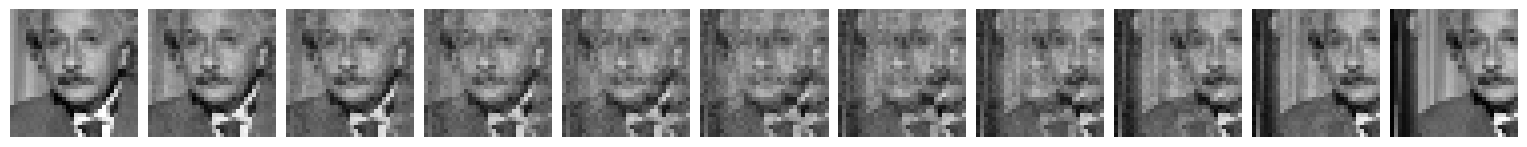

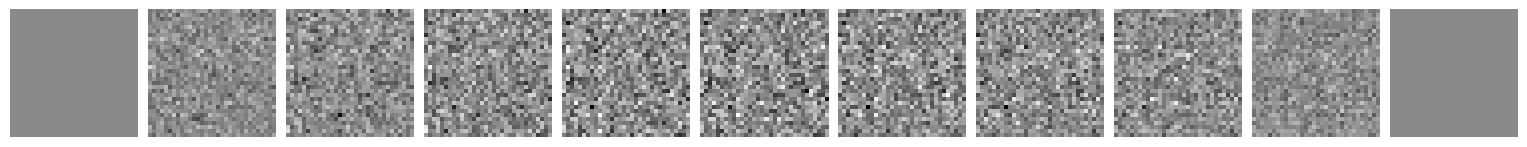

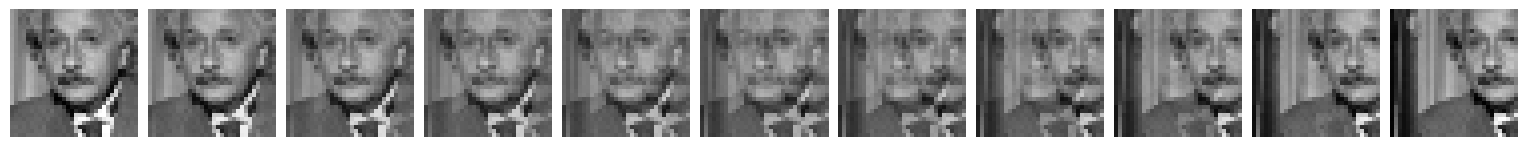

In [11]:
print('geodesic')
pt.imshow(list(geodesic), vrange='auto1', title=None, zoom=4);
print('diff')
pt.imshow(list(geodesic - pixelfade), vrange='auto1', title=None, zoom=4);
print('pixelfade')
pt.imshow(list(pixelfade), vrange='auto1', title=None, zoom=4);

## vgg16 translation / rotation / scaling  

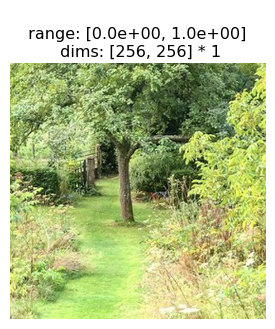

In [95]:
x = po.load_images('../data/frontwindow.jpeg', as_gray=False)
x = torchvision.transforms.functional.center_crop(x, (256, 256))
po.imshow(x, as_rgb=True);

In [96]:
# imgA = torch.tensor(imageA, dtype=dtype).unsqueeze(0).unsqueeze(0)
# imgB = torch.tensor(imageB, dtype=dtype).unsqueeze(0).unsqueeze(0)

# # print(imgA.shape)
# # from plenoptic.tools.straightness import make_straight_line
# # n_steps = 11
# # video = make_straight_line(imgA, imgB, n_steps)
# # print(video.shape)
# # pt.image_stats(po.to_numpy(video).squeeze())
# # pt.animshow(po.to_numpy(video).squeeze(), zoom=2)

# imgA = torch.stack([imgA, imgA, imgA], dim=1).squeeze(2)
# imgB = torch.stack([imgB, imgB, imgB], dim=1).squeeze(2)
# print(imgA.shape)
# po.imshow([imgA, imgB], as_rgb=True, zoom=2);

# # color_img = po.load_images('../data/color_wheel.jpg', as_gray=False)
# # color_img = po.blur_downsample(color_img)
# # color_img = po.blur_downsample(color_img)[..., 11:-11, 11:-11]
# # color_img = po.blur_downsample(color_img)
# # color_img = po.blur_downsample(color_img)
# # imgA = po.rescale(color_img)
# # imgB = torch.transpose(imgA.clone(), 2, 3)
# # po.imshow([imgA, imgB], as_rgb=True, zoom=2);

In [63]:
from torchvision import models
# Create a class that takes the nth layer output of a given model
class NthLayer(torch.nn.Module):
    """Wrap any model to get the response of an intermediate layer
    
    Works for Resnet18 or VGG16.
    
    """
    def __init__(self, model, layer=None):
        """
        Parameters
        ----------
        model: PyTorch model
        layer: int
            Which model response layer to output
        """
        super().__init__()
        try:
            # then this is VGG16
            features = list(model.features)
        except AttributeError:
            # then it's resnet18
            features = ([model.conv1, model.bn1, model.relu, model.maxpool] + [l for l in model.layer1] + 
                        [l for l in model.layer2] + [l for l in model.layer3] + [l for l in model.layer4] + 
                        [model.avgpool, model.fc])
        self.features = nn.ModuleList(features).eval()

        if layer is None:
            layer = len(self.features)
        self.layer = layer

    def forward(self, x):
        for ii, mdl in enumerate(self.features):
            x = mdl(x)
            if ii == self.layer:
                return x

# different potential models of human visual perception of distortions
# resnet18 = NthLayer(models.resnet18(pretrained=True), layer=3)

# choosing what layer representation to study
# for l in range(len(models.vgg16().features)):
#     print(f'({l}) ', models.vgg16().features[l])    
#     print(NthLayer(models.vgg16(pretrained=True), layer=l)(imgA).shape)

vgg_pool1 = NthLayer(models.vgg16(pretrained=True), layer=4)
vgg_pool2 = NthLayer(models.vgg16(pretrained=True), layer=9)
vgg_pool3 = NthLayer(models.vgg16(pretrained=True), layer=17)

In [ ]:
# TODO
# BGR, 0 255, and appropriate centrering

In [80]:
moog = po.synth.Geodesic(imgA, imgB, vgg_pool3)

In [81]:
moog.synthesize(max_iter=100, learning_rate=.001, nu = 0)

  2%|▏         | 20/1000 [00:34<27:49,  1.70s/it, loss=1.5820e+05, gradient norm=9.7873e+03, lr=0.001]


KeyboardInterrupt: 

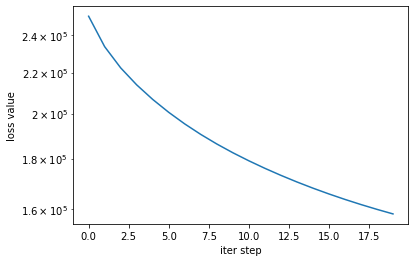

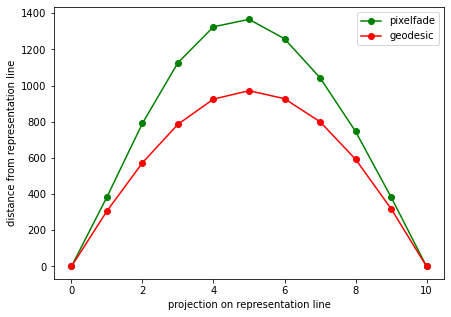

In [82]:
moog.plot_loss()
moog.plot_distance_from_line();

In [85]:
plt.semilogy(po.to_numpy(torch.stack(moog.step_jerkiness)));

RuntimeError: stack expects a non-empty TensorList

In [83]:
moog.geodesic.min(), moog.geodesic.max()

(tensor(0.0078), tensor(1.0008))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


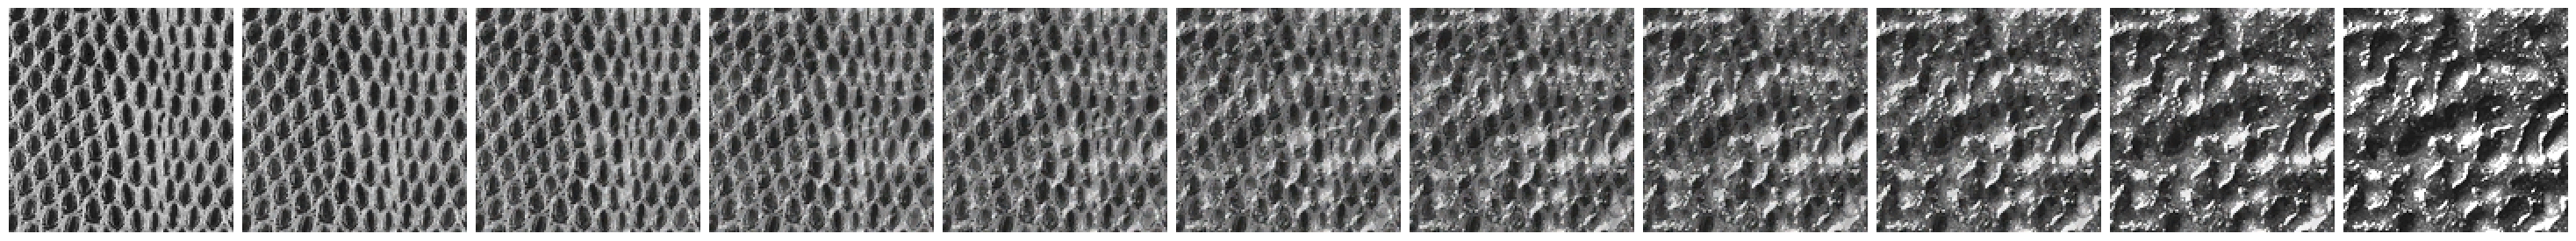

In [84]:
po.imshow(moog.geodesic, as_rgb=True, zoom=2, title=None, vrange='auto0');